In [7]:

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
#import ARLreader as Ar
import preprocessing as prep

In [8]:
def gdas2radiosonde(src_file,dst_file,
        col_names = ['PRES','HGHT','TEMP','UWND',
                     'VWND','WWND','RELH','TPOT','WDIR','WSPD']):
	'''
	Helper function that converts a gdas file from TROPOS server, to a simple txt.
	The resulting file is without any prior info, and resembles the table format
	of a radiosonde file (see class: RadiosondeProfile)
	:param src_file: source file name
	:param dst_file: destination file name
	:param col_names: column names of the final table
	'''
	import pandas as pd
	from pandas.api.types import is_numeric_dtype

	data_src = pd.read_fwf(src_file,skiprows=[0,1,2,3,4,5,6,8],
	                       delimiter="\s+",skipinitialspace=True).dropna()
	# converting any kind of blanc spaces to zeros
	for col in data_src.columns:
		if not is_numeric_dtype(data_src[col]):
			data_src[col]= pd.core.strings.str_strip(data_src[col])
			data_src[col]= data_src[col].replace('','0').astype('float64')
	data_src.columns = col_names
	data_src.to_csv(dst_file,index=False,sep='\t',na_rep='\t')
	# TODO: add warning if failed
def extract_date_time(path,format_filename,format_times):
	# Extracting datetime from file name using a formatter string.
	#
	# Usage:
	# create a formatter string: format_filename=  r'-(.*)_(.*)-(.*)-.*.txt'
	# Call the function:        f time_stamp = extract_date_time(soundePath,r'40179_(.*).txt',['%Y%m%d_%H'])
	# Output:
	#       time_stamps - A list of datetime objects
	import re
	filename = os.path.basename(path)
	#print(filename)
	matchObj = re.match(format_filename, filename, re.M|re.I)
	# print(matchObj)
	time_stamps=[]
	for fmt_time,grp in zip(format_times,matchObj.groups()):
		time_stamps.append(datetime.strptime(grp,fmt_time))
	return time_stamps
def calc_sigma_profile_df(row,lambda_um = 532.0,indx_n= 'sigma'):
	'''
	Returns pd series of extinction profile [1/m] from a radiosonde dataframe containing the
	columns:['PRES','TEMPS',RELHS]. The function applies on rows of the radiosonde df.
	:param row: row of radiosonde df
	:param lambda_um: wavelength in [um], e.g, for green lambda_um = 532.0 [um]
	:param indx_n: index name, the column name of the result. The default is 'sigma'
	but could be useful to get profiles for several hours each have a different index name
	(e.g., datetime object of measuring time of the radiosonde as datetime.datetime(2017, 9, 2, 0, 0))
	:return: pd series of extinction profile [1/m]
	'''
	return pd.Series([rayleigh_scattering.alpha_rayleigh(wavelength= lambda_um,
	                                       pressure=row['PRES'],
	                                       temperature=row['TEMPS'],
	                                       C=385.0, rh=row['RELHS'])],index=[indx_n])
def calc_beta_profile_df(row,lambda_um = 532.0,ind_n= 'beta'):
	"""
	Returns pd series of backscatter profile from a radiosonde dataframe containing the
	columns:['PRES','TEMPS',RELHS]. The function applies on rows of the radiosonde df.
	:param row: row of radiosonde df
	:param lambda_um: wavelength in [um], e.g, for green lambda_um = 532.0 [um]
	:param indx_n: index name, the column name of the result. The default is 'beta'
	but could be useful to get profiles for several hours each have a different index name
	(e.g., datetime object of measuring time of the radiosonde as datetime.datetime(2017, 9, 2, 0, 0))
	:return: pd series of backscatter profile [1/sr*m]
	"""
	return pd.Series([rayleigh_scattering.beta_pi_rayleigh(wavelength= lambda_um,
	                                       pressure=row['PRES'],
	                                       temperature=row['TEMPS'],
	                                       C=385.0, rh=row['RELHS'])],index=[ind_n])

In [9]:
'''set day'''

day_date = datetime(2017,9,1)

'''Set paths to parents folder '''
lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'


In [10]:
lidar_day_folder = os.path.join(lidar_parent_folder,day_date.strftime("%Y\%m\%d"))
os.listdir(lidar_day_folder)
bsc_pattern = os.path.join(lidar_day_folder,"*_att_bsc.nc")
bsc_paths = sorted(glob.glob(bsc_pattern))
#bsc_paths
profile_pattern = os.path.join(lidar_day_folder,"*[0-9]_profiles.nc")
profile_paths = sorted(glob.glob(profile_pattern))
#profile_paths


In [11]:
haifa_station = gs.station
#print(haifa_station.__dict__)
src_folder =os.path.join(os.getcwd(),'data examples\gdas')
dst_folder = os.path.join(os.getcwd(),'data examples\gdas_txt')
gdas_dst_paths= prep.gdas_tropos2txt(day_date, haifa_station.location,
                                   haifa_station.lat, haifa_station.lon,
                                   src_folder, dst_folder)

''' LEGACY --> replaced by prep.gdas_tropos2txt
#set source gdas files
# TODO: Add namings and existing path validation (print warnings and errors)
src_folder = os.path.join(os.getcwd(),'data examples/gdas')
gdas_curd_pattern = 'haifa_{}_*_{}_{}.gdas1'.\
	format(day_date.strftime('%Y%m%d'),haifa_station.lat,haifa_station.lon)
gdas_nxtd_pattern = 'haifa_{}_00_{}_{}.gdas1'.\
	format((day_date+timedelta(days=1)).strftime('%Y%m%d'),haifa_station.lat,haifa_station.lon)
gdas_src_paths = sorted(glob.glob(os.path.join(src_folder,gdas_curd_pattern)))
gdas_src_paths.append(os.path.join(src_folder,gdas_nxtd_pattern))

# set dest txt files
dst_folder = os.path.join(os.getcwd(),'/data examples/gdas_txt')
# TODO: Add validation and indicate if folder already existed or created now (print warnings and errors)
from pathlib import Path
Path(dst_folder).mkdir(parents=True, exist_ok=True)
gdas_dst_paths = [sub.replace(src_folder, dst_folder).
	                  replace('gdas1','txt') for sub in gdas_src_paths]
for (src_file,dst_file) in zip(gdas_src_paths,gdas_dst_paths):
	gdas2radiosonde(src_file,dst_file)

	# print('\n Done conversion src: ',src_file,'dst: ',dst_file)
	#sanity check
	#data_dst =pd.read_csv(dst_file,delimiter="\s+")
	#print(data_dst)
'''
# TODO : set 'gdas_src_paths' and 'src_folder' according to 'start_date' and 'end_date' -
#  for conversion of a big chunk of gdas files. See examples below.
# TODO : set 'gdas_dst_paths' in similar way. Such that the folders of gdas and txt files will have same tree
#  (or just save it in the same folders?)
'''gdas_month_folder = os.path.join(gdas_parent_folder, day_date.strftime("%Y\%m"))
#print (os.path.exists(gdas_month_folder))

gdas_cur_pattern = 'haifa_{}_*_{}_{}.gdas1'.format(day_date.strftime('%Y%m%d'),gs.lat,gs.lon)
gdas_next = 'haifa_{}_00_{}_{}.gdas1'.format((day_date+timedelta(days=1)).strftime('%Y%m%d'),gs.lon,gs.lat)
gdas_pattern  = os.path.join(gdas_month_folder,gdas_cur_pattern)
gdas_paths = sorted(glob.glob(gdas_pattern))
gdas_paths.append(os.path.join(gdas_month_folder,gdas_next))
#gdas_file = Ar.fname_from_date(day_date)
#print('name of input file ', gdas_pattern)'''

'gdas_month_folder = os.path.join(gdas_parent_folder, day_date.strftime("%Y\\%m"))\n#print (os.path.exists(gdas_month_folder))\n\ngdas_cur_pattern = \'haifa_{}_*_{}_{}.gdas1\'.format(day_date.strftime(\'%Y%m%d\'),gs.lat,gs.lon)\ngdas_next = \'haifa_{}_00_{}_{}.gdas1\'.format((day_date+timedelta(days=1)).strftime(\'%Y%m%d\'),gs.lon,gs.lat)\ngdas_pattern  = os.path.join(gdas_month_folder,gdas_cur_pattern)\ngdas_paths = sorted(glob.glob(gdas_pattern))\ngdas_paths.append(os.path.join(gdas_month_folder,gdas_next))\n#gdas_file = Ar.fname_from_date(day_date)\n#print(\'name of input file \', gdas_pattern)'

In [12]:
'''set parameters'''
lambda_um = gs.LAMBDA_um.G
location = haifa_station.location
min_height_km = (1E-3)*(haifa_station.altitude + haifa_station.start_bin_height)
top_height_km = (1E-3)*(haifa_station.altitude + haifa_station.end_bin_height)

df_sigma, df_beta = prep.generate_daily_molecular_profile(
	gdas_dst_paths,lambda_um,haifa_station.location, haifa_station.lat,
	haifa_station.lon,min_height_km , top_height_km,haifa_station.n_bins)

df_sigma

,2017-09-01 00:00:00,2017-09-01 03:00:00,2017-09-01 06:00:00,2017-09-01 09:00:00,2017-09-01 12:00:00,2017-09-01 15:00:00,2017-09-01 18:00:00,2017-09-01 21:00:00,2017-09-02 00:00:00
0.307750,1.222132e-05,1.221421e-05,1.219077e-05,1.216900e-05,1.215608e-05,1.214148e-05,1.214498e-05,1.215416e-05,1.215908e-05
0.315221,1.221402e-05,1.220682e-05,1.218334e-05,1.216172e-05,1.214879e-05,1.213427e-05,1.213771e-05,1.214688e-05,1.215153e-05
0.322693,1.220671e-05,1.219947e-05,1.217588e-05,1.215442e-05,1.214149e-05,1.212705e-05,1.213043e-05,1.213961e-05,1.214398e-05
0.330164,1.219940e-05,1.219212e-05,1.216842e-05,1.214713e-05,1.213418e-05,1.211983e-05,1.212315e-05,1.213233e-05,1.213643e-05
0.337636,1.219209e-05,1.218476e-05,1.216096e-05,1.213983e-05,1.212688e-05,1.211260e-05,1.211587e-05,1.212505e-05,1.212888e-05
...,...,...,...,...,...,...,...,...,...
22.684774,7.140280e-07,7.148756e-07,7.163237e-07,7.162552e-07,7.142508e-07,7.143293e-07,7.141014e-07,7.141460e-07,7.125847e-07
22.692246,7.132981e-07,7.141467e-07,7.155945e-07,7.155249e-07,7.135222e-07,7.136011e-07,7.133720e-07,7.134145e-07,7.118500e-07
22.699717,7.125684e-07,7.134180e-07,7.148654e-07,7.147947e-07,7.127937e-07,7.128729e-07,7.126427e-07,7.126830e-07,7.111154e-07
22.707189,7.118387e-07,7.126894e-07,7.141364e-07,7.140646e-07,7.120652e-07,7.121449e-07,7.119135e-07,7.119517e-07,7.103810e-07


In [13]:
#dr = 7.47e-3       # Height resolution dr~= 7.5e-3[km] (similar to the lidar height resolution)
#heights = np.linspace(min_height, top_height,haifa_station.n_bins)
#print(heights.shape,min_height,top_height, heights[1]-heights[0])

''' LEGACY -->  replaced by prep.generate_daily_molecular_profile

df_sigma = pd.DataFrame()
df_beta = pd.DataFrame()

for dst_file in gdas_dst_paths:
	df_sonde = RadiosondeProfile(dst_file).get_df_sonde(heights)
	#df_sonde = sondeprofile.get_df_sonde(heights)
	time = extract_date_time(dst_file,r'haifa_(.*)_32.8_35.0.txt',['%Y%m%d_%H'])[0]
	#Calculating molecular profiles from temperature and pressure
	res = df_sonde.apply(calc_sigma_profile_df,axis = 1,args=(lambda_um,time,),result_type='expand').astype('float64')
	df_sigma[res.columns]=res
	res = df_sonde.apply(calc_beta_profile_df,axis = 1,args=(lambda_um,time,),result_type='expand').astype('float64')
	df_beta[res.columns]=res
'''

" LEGACY -->  replaced by prep.generate_daily_molecular_profile\n\ndf_sigma = pd.DataFrame()\ndf_beta = pd.DataFrame()\n\nfor dst_file in gdas_dst_paths:\n\tdf_sonde = RadiosondeProfile(dst_file).get_df_sonde(heights)\n\t#df_sonde = sondeprofile.get_df_sonde(heights)\n\ttime = extract_date_time(dst_file,r'haifa_(.*)_32.8_35.0.txt',['%Y%m%d_%H'])[0]\n\t#Calculating molecular profiles from temperature and pressure\n\tres = df_sonde.apply(calc_sigma_profile_df,axis = 1,args=(lambda_um,time,),result_type='expand').astype('float64')\n\tdf_sigma[res.columns]=res\n\tres = df_sonde.apply(calc_beta_profile_df,axis = 1,args=(lambda_um,time,),result_type='expand').astype('float64')\n\tdf_beta[res.columns]=res\n"

<Figure size 432x288 with 0 Axes>

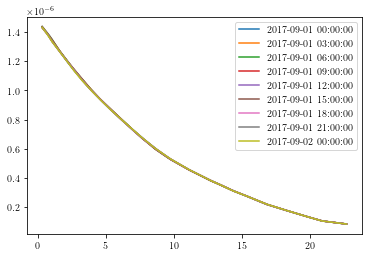

In [14]:
plt.figure()
df_beta.plot()
plt.show()

In [15]:
# TODO: check 2D interpolation in transformation (see link below)
'''@ https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

instead of append, load the profiles to dataframe and then create an image.
treat every row of the dataframe as a time series. so the interpolation is done per row.
from 00:00,03:00,06:00,09:00,12:00,15:00,18:00,21:00,24:00 to 00:00-24:00 with intervals of 30 sec'''
import matplotlib.dates as mdates
def cal_e_tau_df(col,altitude):
	heights = col.index.to_numpy()-haifa_station.altitude
	dr =np.insert(heights[1:]-heights[0:-1], 0, heights[0])
	tau = np.cumsum(col * dr, axis=0)
	return pd.Series(np.exp(-2 * tau))

In [44]:
def generate_att_bsc_mol(df_sigma, df_beta,station, time_res='30S'):
	interp_sigma_df=(df_sigma.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_beta_df=(df_beta.T.resample(time_res).interpolate(method='linear')[:-1]).T
	heights = np.linspace(station.altitude+station.start_bin_height,
                      station.altitude+station.end_bin_height,
                      station.n_bins)
	interp_sigma_df.index=heights
	interp_sigma_df.columns.freq=None
	interp_beta_df.index=heights
	interp_beta_df.columns.freq=None
	tau_df = interp_sigma_df.apply(cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
	att_bsc_mol_df = interp_beta_df.multiply(interp_sigma_df.apply(cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand'))
	import xarray as xr
	mol_xr= xr.DataArray(data=[interp_beta_df,interp_sigma_df,att_bsc_mol_df],
                     coords=[['beta','sigma','att_bsc_mol'],interp_beta_df.index,interp_beta_df.columns],
                     dims = ['profiles','height','time'],
                     name='molecular')#,interp_beta_df.index,interp_beta_df.columns )



	return att_bsc_mol_df,mol_xr
'''
interp_sigma_df=(df_sigma.T.resample('30S').interpolate(method='linear')[:-1]).T
interp_beta_df=(df_beta.T.resample('30S').interpolate(method='linear')[:-1]).T
heights = np.linspace(haifa_station.altitude+haifa_station.start_bin_height,
                      haifa_station.altitude+haifa_station.end_bin_height,
                      haifa_station.n_bins)

interp_sigma_df.index=heights
interp_sigma_df.columns.freq=None
#interp_sigma_df.columns.to_pydatetime()

interp_beta_df.index=heights
interp_beta_df.columns.freq=None
#interp_beta_df.columns.to_pydatetime()



tau_df = interp_sigma_df.apply(cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
mol_df = interp_beta_df.multiply(interp_sigma_df.apply(cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand'))
'''

print('df_mol')
mol_df,mol_xr = generate_att_bsc_mol(df_sigma, df_beta,haifa_station, time_res='30S')
mol_xr
# TODO: make sure mol_df units has consistant units 1/m vs 1/km
# TODO: define attributes of mol_xr
# TODO: create xarray to a daily molecular profile for three channels
# TODO: convert from xarray to pytorch

df_mol


<xarray.DataArray 'molecular' (profiles: 3, height: 3000, time: 2880)>
array([[[1.43876581e-06, 1.43876355e-06, 1.43876129e-06, ...,
         1.43152413e-06, 1.43152573e-06, 1.43152734e-06],
        [1.43790604e-06, 1.43790375e-06, 1.43790147e-06, ...,
         1.43063545e-06, 1.43063697e-06, 1.43063848e-06],
        [1.43704599e-06, 1.43704369e-06, 1.43704139e-06, ...,
         1.42974639e-06, 1.42974782e-06, 1.42974924e-06],
        ...,
        [8.38648559e-08, 8.38651337e-08, 8.38654115e-08, ...,
         8.36953909e-08, 8.36948784e-08, 8.36943660e-08],
        [8.37789800e-08, 8.37792581e-08, 8.37795362e-08, ...,
         8.36089534e-08, 8.36084399e-08, 8.36079264e-08],
        [8.36931164e-08, 8.36933948e-08, 8.36936732e-08, ...,
         8.35225293e-08, 8.35220147e-08, 8.35215002e-08]],

       [[1.22213220e-05, 1.22213023e-05, 1.22212825e-05, ...,
         1.21590354e-05, 1.21590491e-05, 1.21590627e-05],
        [1.22140184e-05, 1.22139984e-05, 1.22139784e-05, ...,
         1.21514925e-05, 1.21515054e-05, 1.21515183e-05],
        [1.22067123e-05, 1.22066922e-05, 1.22066721e-05, ...,
         1.21439463e-05, 1.21439585e-05, 1.21439706e-05],
...
        [7.12568384e-07, 7.12570744e-07, 7.12573104e-07, ...,
         7.11128503e-07, 7.11124149e-07, 7.11119794e-07],
        [7.11838728e-07, 7.11841091e-07, 7.11843454e-07, ...,
         7.10394076e-07, 7.10389713e-07, 7.10385350e-07],
        [7.11109177e-07, 7.11111543e-07, 7.11113908e-07, ...,
         7.09659762e-07, 7.09655390e-07, 7.09651018e-07]],

       [[1.43599905e-06, 1.43599680e-06, 1.43599455e-06, ...,
         1.42878531e-06, 1.42878691e-06, 1.42878851e-06],
        [1.43487903e-06, 1.43487675e-06, 1.43487447e-06, ...,
         1.42763908e-06, 1.42764059e-06, 1.42764210e-06],
        [1.43375924e-06, 1.43375695e-06, 1.43375466e-06, ...,
         1.42649301e-06, 1.42649442e-06, 1.42649584e-06],
        ...,
        [6.81102815e-08, 6.81105007e-08, 6.81107199e-08, ...,
         6.79896568e-08, 6.79892503e-08, 6.79888438e-08],
        [6.80398142e-08, 6.80400337e-08, 6.80402531e-08, ...,
         6.79187186e-08, 6.79183113e-08, 6.79179039e-08],
        [6.79693591e-08, 6.79695789e-08, 6.79697986e-08, ...,
         6.78477935e-08, 6.78473853e-08, 6.78469771e-08]]])
Coordinates:
  * profiles  (profiles) <U11 'beta' 'sigma' 'att_bsc_mol'
  * height    (height) float64 307.8 315.2 322.7 ... 2.271e+04 2.271e+04
  * time      (time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30

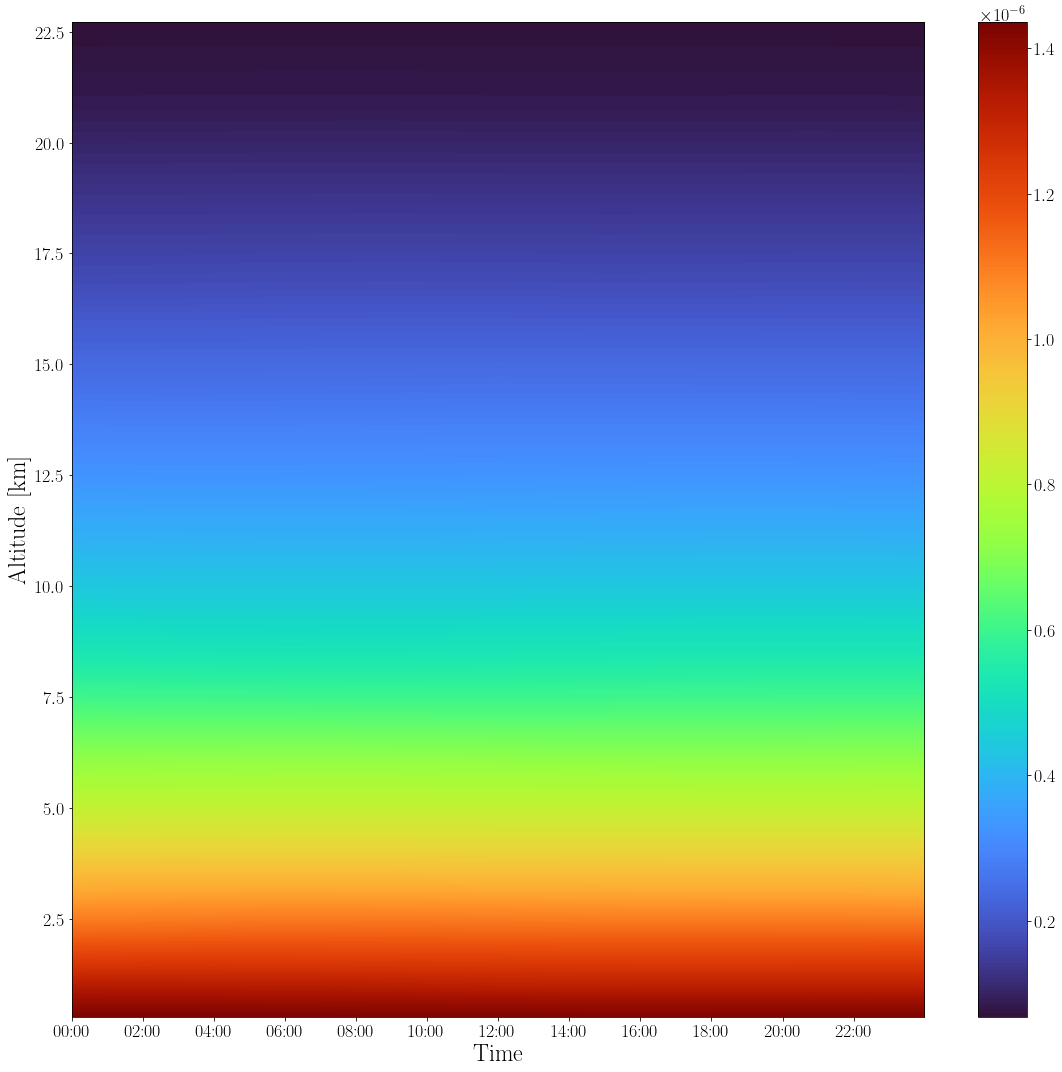

In [43]:
cur_df= mol_df
x_lims = mdates.date2num([cur_df.columns[0],cur_df.columns[-1]])
y_lims = [cur_df.index[0]*1E-3, cur_df.index[-1]*1E-3]
extent = [x_lims[0],x_lims[1],y_lims[0],y_lims[1] ]
fig, ax = plt.subplots(figsize=(16,15))
im = ax.imshow(cur_df, origin='lower',aspect='auto',cmap = 'turbo',
               extent=extent)#[0,2779,interp_sigma_df.index[0], interp_sigma_df.index[-1]])

ax.set_ylabel('Altitude [km]',fontsize =24)
ax.set_xlabel('Time',fontsize =24)
plt.rc('xtick',labelsize =18)
plt.rc('ytick',labelsize=18)
fig.colorbar(im,ax= ax)
ax.xaxis_date()
ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=120))
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig.tight_layout()
plt.show()

In [21]:
''' read radiosonde at 00:00 and 12:00 and 00:00 (of the day after)'''
## radiosonde download and analysis from cameranetwork

''' read gdas data for 00:00, 03:00, 06:00, 09:00 ,12:00, 15:00 , 18:00 ,21:00, 24:00'''
## use: https://github.com/martin-rdz/ARLreader


## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.
''' Interpolate on molecular profiles on a 2D grid 00:00-23:59 '''

' Interpolate on molecular profiles on a 2D grid 00:00-23:59 '

In [22]:
# for the followings :
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}